In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Parallel processing comparation between OpenMP, CUDA and MPI
We start by loading the benchmark results into a data frame and aggregating multiple runs by geometric mean

In [2]:
# Declare index structure
col = ("test250", "test500", "test750", "test1", "test1.5", "test2", "test2.5", "test3", "test3.5", "test4", "test4.5")
scol = [str(i) for i in range(1,8)]
mcol = pd.MultiIndex.from_product([col,scol])

row =  ("seq", "omp", "cuda", "mpi", "mpi_br")
srow = ("cycles", "real_time_nsec", "PAPI_TOT_INS", "PAPI_TOT_CYC")
mrow = pd.MultiIndex.from_product([row,srow])

row = ("mpi", "mpi_br")
sr_row = ("Send", "Recv")
sr_mrow = pd.MultiIndex.from_product([row, sr_row, srow])

# Recollect data
df = pd.DataFrame(np.loadtxt("results/main-results-v4.csv", delimiter=','), index=mrow, columns=mcol)
sr_df = pd.DataFrame(np.loadtxt("results/mpi_sr-results.csv", delimiter=','), index=sr_mrow, columns=mcol)

# Compute geometric mean for total cpu time and send/recive time
gmean = pd.DataFrame(np.full((mrow.size, len(col)), np.nan), index=mrow, columns=col)
sr_gmean = pd.DataFrame(np.full((sr_mrow.size, len(col)), np.nan), index=sr_mrow, columns=col)
for c in col:
    gmean[c] = df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")
    sr_gmean[c] = sr_df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")


# Display geometric mean dataframe
gmean


test250       test500       test750         test1  \
seq    cycles          1.673387e+08  1.400288e+09  5.168005e+09  1.433770e+10   
       real_time_nsec  5.232133e+07  4.378439e+08  1.615942e+09  4.483145e+09   
       PAPI_TOT_INS    4.075696e+08  3.255260e+09  1.098058e+10  2.602102e+10   
       PAPI_TOT_CYC    1.738307e+08  1.451016e+09  5.384591e+09  1.499463e+10   
omp    cycles          4.444127e+07  3.716906e+08  1.349542e+09  3.549884e+09   
       real_time_nsec  1.389178e+07  1.162130e+08  4.219572e+08  1.109934e+09   
       PAPI_TOT_INS    1.061682e+08  8.466837e+08  2.851691e+09  6.756734e+09   
       PAPI_TOT_CYC    4.347740e+07  3.532998e+08  1.321587e+09  3.422319e+09   
cuda   cycles          6.113518e+08  6.550990e+08  1.551534e+09  3.288008e+09   
       real_time_nsec  1.911505e+08  2.048298e+08  4.851213e+08  1.028072e+09   
       PAPI_TOT_INS    1.596837e+08  1.014361e+09  2.947688e+09  6.494564e+09   
       PAPI_TOT_CYC    8.616050e+07  5.132214e+08  1.453668e+09  3.259434e+09   
mpi    cycles          4.757996e+08  1.465509e+09  3.515197e+09  6.100154e+09   
       real_time_nsec  1.487698e+08  4.582320e+08  1.099129e+09  1.907385e+09   
       PAPI_TOT_INS    2.018291e+08  6.024138e+08  1.564688e+09  3.083125e+09   
       PAPI_TOT_CYC    9.586840e+07  3.082886e+08  8.974080e+08  1.853989e+09   
mpi_br cycles          4.508604e+08  1.049612e+09  2.623396e+09  4.661266e+09   
       real_time_nsec  1.409717e+08  3.281887e+08  8.202806e+08  1.457481e+09   
       PAPI_TOT_INS    6.627319e+08  6.960925e+08  1.706900e+09  3.354929e+09   
       PAPI_TOT_CYC    2.406821e+08  3.172151e+08  9.115288e+08  1.791463e+09   

                            test1.5         test2       test2.5         test3  \
seq    cycles          6.279546e+10  1.261305e+11  2.900260e+11  4.165637e+11   
       real_time_nsec  1.963483e+10  3.943876e+10  9.068526e+10  1.302521e+11   
       PAPI_TOT_INS    8.779729e+10  2.080841e+11  4.063814e+11  7.021892e+11   
       PAPI_TOT_CYC    6.261429e+10  1.321494e+11  2.894857e+11  4.365239e+11   
omp    cycles          1.616566e+10  3.267203e+10  7.747911e+10  1.020482e+11   
       real_time_nsec  5.054658e+09  1.021551e+10  2.422608e+10  3.190734e+10   
       PAPI_TOT_INS    2.279524e+10  5.402473e+10  1.055051e+11  1.823011e+11   
       PAPI_TOT_CYC    1.470458e+10  3.189985e+10  7.112760e+10  9.965204e+10   
cuda   cycles          1.126163e+10  2.488206e+10  4.859853e+10  8.317345e+10   
       real_time_nsec  3.521273e+09  7.779971e+09  1.519575e+10  2.600620e+10   
       PAPI_TOT_INS    2.178860e+10  5.309459e+10  1.012159e+11  1.803901e+11   
       PAPI_TOT_CYC    1.077591e+10  2.588560e+10  4.920768e+10  8.707335e+10   
mpi    cycles          1.865240e+10  3.770652e+10  7.468561e+10  1.215490e+11   
       real_time_nsec  5.832204e+09  1.179002e+10  2.335260e+10  3.800579e+10   
       PAPI_TOT_INS    9.930011e+09  2.255157e+10  4.379357e+10  7.560092e+10   
       PAPI_TOT_CYC    7.035095e+09  1.522107e+10  3.274160e+10  4.923946e+10   
mpi_br cycles          1.546203e+10  3.184474e+10  6.616529e+10  1.083525e+11   
       real_time_nsec  4.834666e+09  9.957212e+09  2.068856e+10  3.387966e+10   
       PAPI_TOT_INS    1.078773e+10  2.452023e+10  4.802330e+10  8.410523e+10   
       PAPI_TOT_CYC    6.692365e+09  1.558832e+10  3.340220e+10  4.755466e+10   

                            test3.5         test4       test4.5  
seq    cycles          9.056659e+11  1.244813e+12  2.003902e+12  
       real_time_nsec  2.831838e+11  3.892223e+11  6.265785e+11  
       PAPI_TOT_INS    1.115008e+12  1.664336e+12  2.369676e+12  
       PAPI_TOT_CYC    9.085283e+11  1.303387e+12  2.018170e+12  
omp    cycles          2.853180e+11  3.579617e+11  6.151306e+11  
       real_time_nsec  8.921292e+10  1.119246e+11  1.923386e+11  
       PAPI_TOT_INS    2.894765e+11  4.320903e+11  6.152067e+11  
       PAPI_TOT_CYC    2.592454e+11  3.485590e+11  5.558442e+11  
cuda   cycles          6.10317

The data is structured by the computation technique and tecnology used.

## Comparing speed-ups between the different techniques

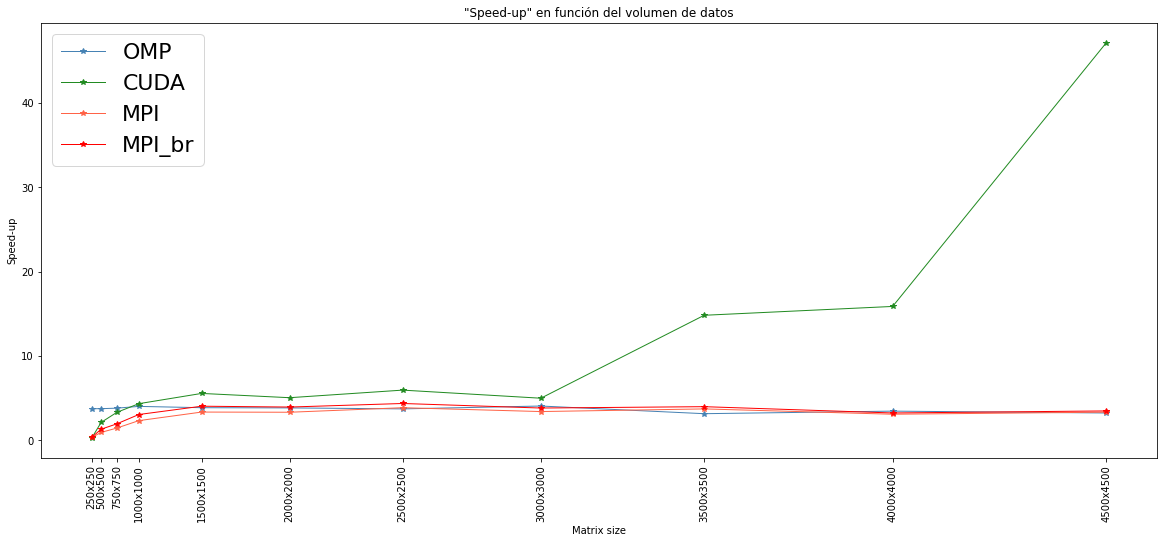

In [36]:
omp_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["omp", "real_time_nsec"])
cuda_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda", "real_time_nsec"])
mpi_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi", "real_time_nsec"])
mpi_br_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi_br", "real_time_nsec"])

xaxis = np.array([250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])**2

fig, ax = plt.subplots()

xlabel = ['250x250', '500x500', '750x750', '1000x1000', '1500x1500', '2000x2000', '2500x2500','3000x3000', '3500x3500','4000x4000', '4500x4500']
edgewidth = 1

ax.plot(xaxis, omp_sp,'*-', label='OMP', color="steelblue", linewidth=edgewidth)
ax.plot(xaxis, cuda_sp, '*-', color="forestgreen", label='CUDA', linewidth=edgewidth)
ax.plot(xaxis, mpi_sp, '*-', color="tomato", label='MPI', linewidth=edgewidth)
ax.plot(xaxis, mpi_br_sp, '*-', color="red", label='MPI_br', linewidth=edgewidth)

ax.set_title("\"Speed-up\" en función del volumen de datos")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Matrix size")
ax.set_xticks(xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.legend(fontsize=22)

# Añadir separación realista eje x
# Arreglar esta mierda cabrón

fig.set_size_inches((20, 8))

plt.show()


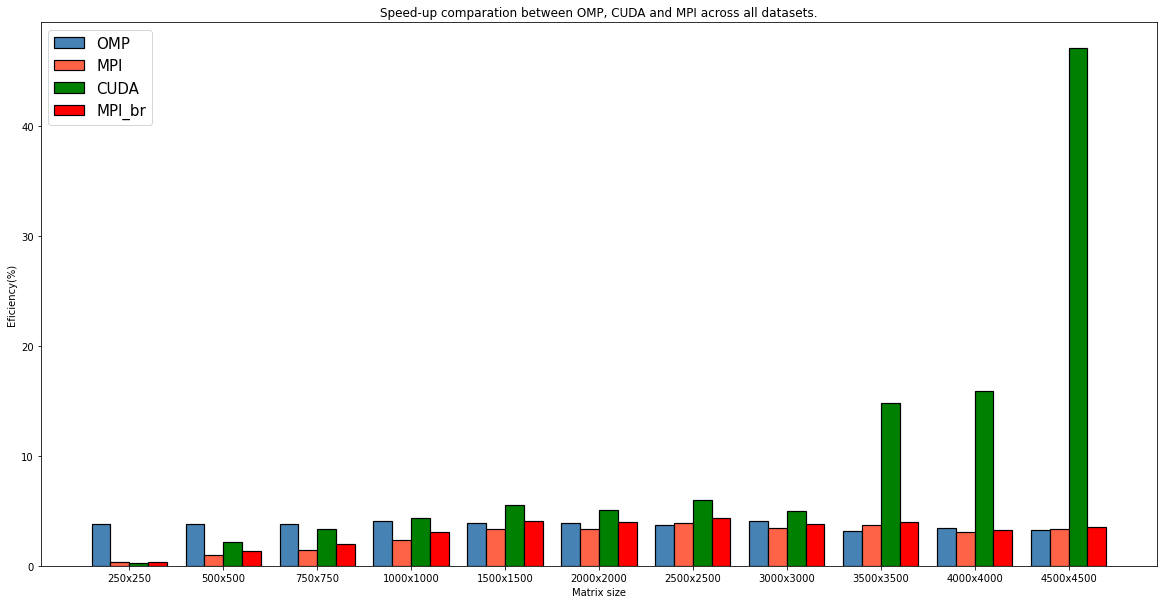

In [4]:
fig, ax = plt.subplots()

xaxis = np.arange(1, len(xlabel)*1.25+1, 1.25)
width = 0.25
edgewidth = 1.2

ax.bar(xaxis - 1.5*width, omp_sp, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis - width/2, mpi_sp, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width/2, cuda_sp, width, color="green", label='CUDA', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + 1.5*width, mpi_br_sp, width, color="red", label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Speed-up comparation between OMP, CUDA and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=15)

fig.set_size_inches((20,10))

plt.show()

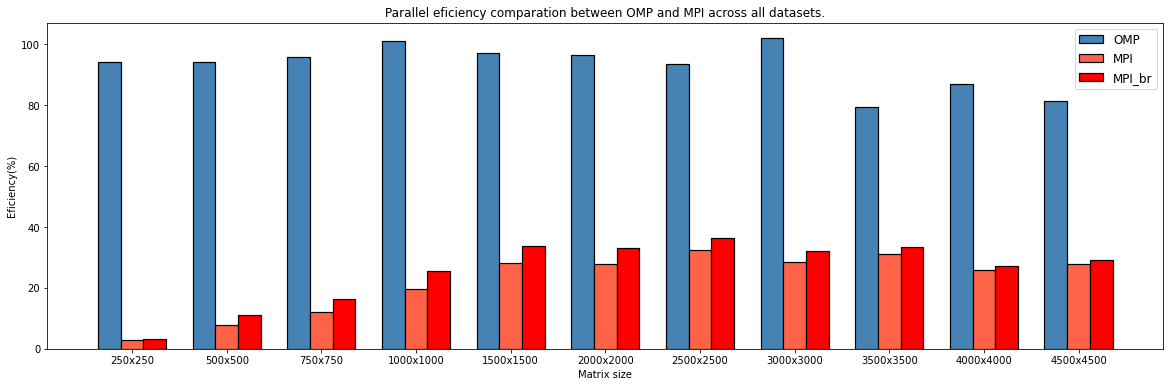

In [5]:
omp_cores = 4
mpi_cores = 12

omp_ef =    100*omp_sp/omp_cores
mpi_ef =    100*mpi_sp/mpi_cores
mpi_br_ef = 100*mpi_br_sp/mpi_cores

fig, ax = plt.subplots()

xaxis = np.arange(1, len(xlabel)*1.25+1, 1.25)
width = 0.3
edgewidth = 1.2

ax.bar(xaxis - width, omp_ef, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis , mpi_ef, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width, mpi_br_ef, width, color="red", label='MPI_br', edgecolor='black', linewidth=edgewidth)

ax.set_title("Parallel eficiency comparation between OMP and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=12)

fig.set_size_inches((20,6))

plt.show()


In [ ]:
xaxis = np.arange(len(xlabel))

mpi_tcpu_per = sr_gmean.loc["mpi"]

ax.bar(xaxis-width/2, st, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, st_br, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

fig, ax = plt.subplots()
ax.bar(xaxis-width/2, st, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, st_br, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

# COMPARACIÓN ENTRE EL TIEMPO DE ENVÍO DE POR FILAS Y POR ELEMENTOS (MATRIZ ENTERA)

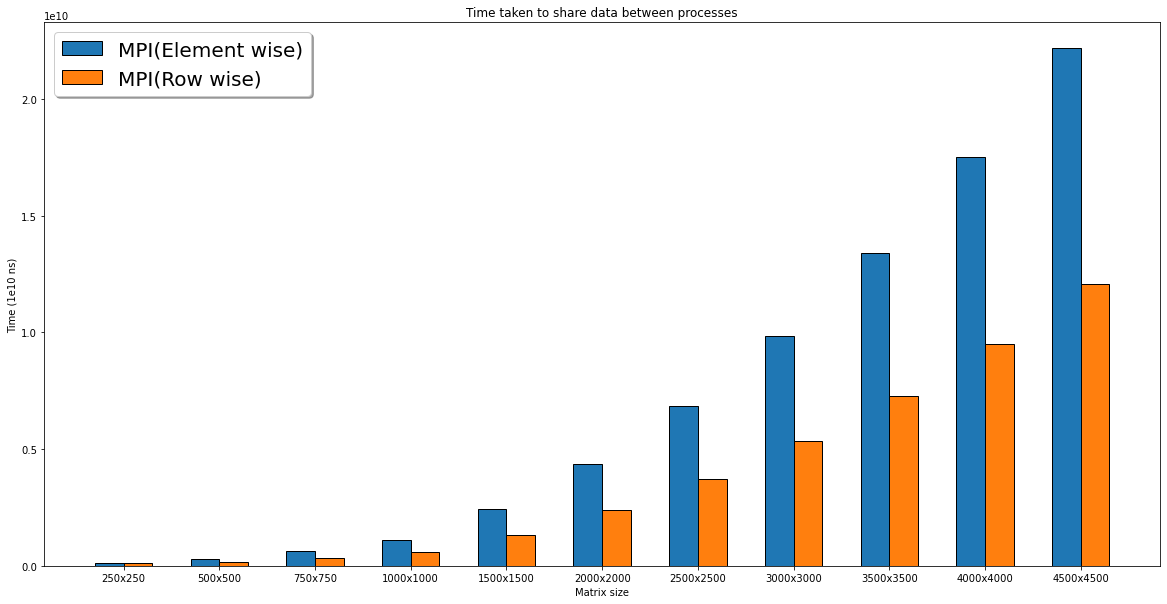

In [55]:
st = sr_gmean.loc["mpi", "Send", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Send", "real_time_nsec"]

fig, ax = plt.subplots()
ax.bar(xaxis-width/2, st, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, st_br, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

ax.set_title("Time taken to share data between processes")
ax.set_ylabel("Time (1e10 ns)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)


fig.set_size_inches((20,10))

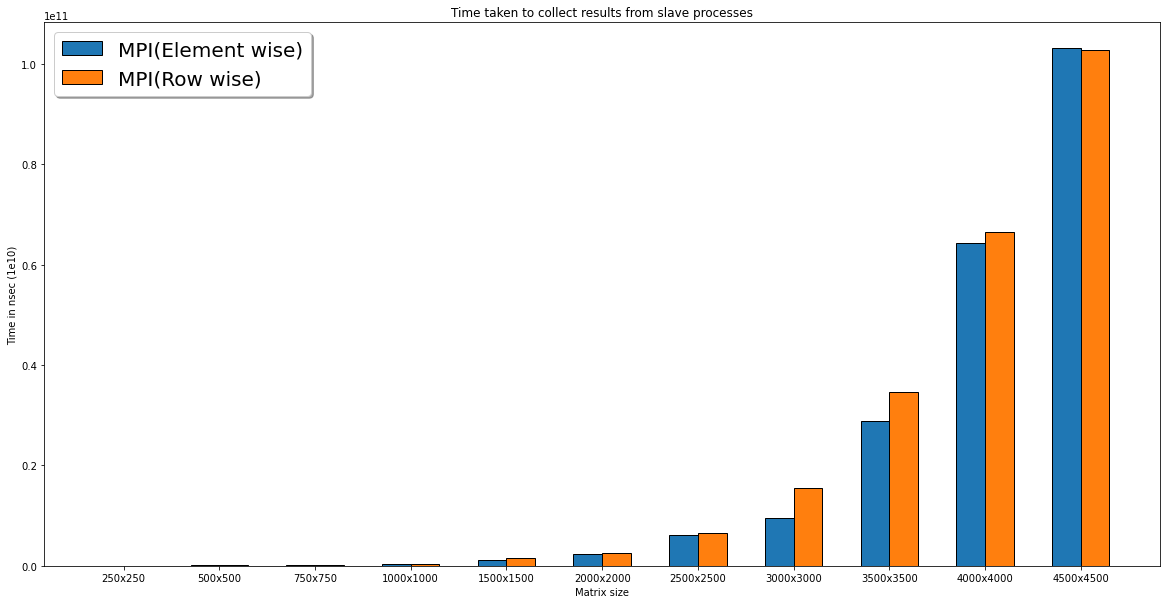

In [56]:
st = sr_gmean.loc["mpi", "Recv", "real_time_nsec"]
st_br = sr_gmean.loc["mpi_br", "Recv", "real_time_nsec"]

fig, ax = plt.subplots()
ax.bar(xaxis-width/2, st, width, label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, st_br, width, label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

ax.set_title("Time taken to collect results from slave processes")
ax.set_ylabel("Time in nsec (1e10)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=20, shadow=True, fancybox=True)


fig.set_size_inches((20,10))

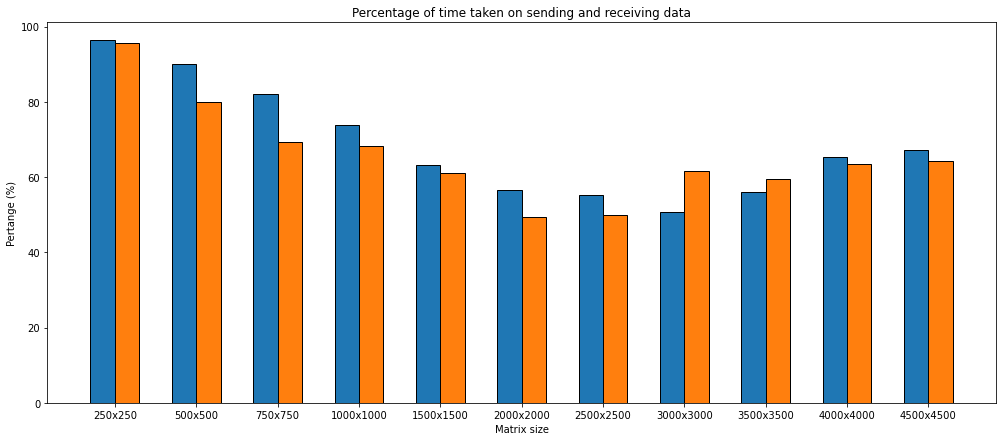

In [81]:
mpi_sr_time_per = 100*sr_gmean.loc["mpi", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi", "real_time_nsec"]
mpi_br_sr_time_per = 100*sr_gmean.loc["mpi_br", :, sr_gmean.index.get_level_values(2)=='real_time_nsec'].aggregate(sum) / gmean.loc["mpi_br", "real_time_nsec"]


fig, ax = plt.subplots()
ax.bar(xaxis-width/2, mpi_sr_time_per, width,label='MPI(Element wise)',edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis+width/2, mpi_br_sr_time_per, width,label='MPI(Row wise)',edgecolor='black', linewidth=edgewidth)

ax.set_title("Percentage of time taken on sending and receiving data")
ax.set_ylabel("Pertange (%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)

fig.set_size_inches((17,7))